# Project Simulation & Optimization
Given is a rod with cross-section $A$, length $l$ and thermal conductivity $\lambda$, exposed to a constant heat supply $Q_0$ along the rod.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
Integrating and using the boundary conditions $T(0)=0$ and $T(l)=0$ yields:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0\,l}{2\,\lambda\,A}\,x$

### System Parameters

In [79]:
Q0 = 15 # J/m^2s
lamb = 5 # J/°Cms
Across = 1e-4 # m^2
l = 1 # m

### Analytical Function of $T$

Text(0, 0.5, 'temperature on beam in °C')

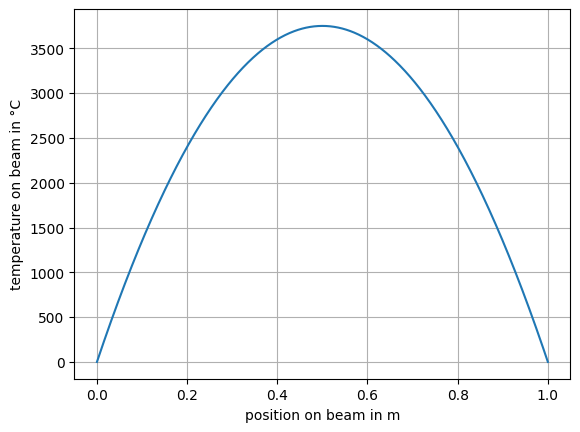

In [80]:
def T(x):
    return -Q0/(2*lamb*Across)*x**2 + Q0/(2*lamb*Across)*x

def T_dd(x):
    return np.ones_like(x)*-Q0/(2*lamb*Across)

x = np.linspace(0, 1, 900)
T_analytic = T(x)
plt.plot(x, T_analytic)
plt.grid()
plt.xlabel("position on beam in m")
plt.ylabel("temperature on beam in °C")

### System of equations: finite difference method
To make matrix A symmetric, the first and last element are left out (boundary conditions) and added after solving the rest.

In [89]:
n = np.size(x)-2
h = x[1] - x[0]

A = (2*np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1))
A = A / h**2

b = np.full(n, Q0 / (lamb * Across))

print(A)

# sparse matrix implementation A ( (row,col) val )
import scipy.sparse as sp
spA = sp.csr_matrix(A)
print(spA)
print(spA[1,1])

[[1616402. -808201.       0. ...       0.       0.       0.]
 [-808201. 1616402. -808201. ...       0.       0.       0.]
 [      0. -808201. 1616402. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ... 1616402. -808201.       0.]
 [      0.       0.       0. ... -808201. 1616402. -808201.]
 [      0.       0.       0. ...       0. -808201. 1616402.]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2692 stored elements and shape (898, 898)>
  Coords	Values
  (0, 0)	1616402.0
  (0, 1)	-808201.0
  (1, 0)	-808201.0
  (1, 1)	1616402.0
  (1, 2)	-808201.0
  (2, 1)	-808201.0
  (2, 2)	1616402.0
  (2, 3)	-808201.0
  (3, 2)	-808201.0
  (3, 3)	1616402.0
  (3, 4)	-808201.0
  (4, 3)	-808201.0
  (4, 4)	1616402.0
  (4, 5)	-808201.0
  (5, 4)	-808201.0
  (5, 5)	1616402.0
  (5, 6)	-808201.0
  (6, 5)	-808201.0
  (6, 6)	1616402.0
  (6, 7)	-808201.0
  (7, 6)	-808201.0
  (7, 7)	1616402.0
  (7, 8)	-808201.0
  (8, 7)	-808201.0
  (8, 8)	1616402.0
  :	:
  (889, 889)	1616402.0
  (

### Benchmark decorator

In [82]:
import time

# time recorder decorator (inspired by Matthias Panny)
def timedit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in: {execution_time:.4f} seconds")
        return result
    return wrapper

### Solver implementations

#### helper functions

In [83]:
def backward_sub(U, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += U[i, j] * x[j]
        x[i] = (b[i] - s) / U[i, i]
    return x

def forward_sub(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
    return y

def apply_init_conditions(T, T0, TE):
    T_new = np.zeros(np.size(T)+2)
    T_new[1:-1] = T
    T_new[0] = T0
    T_new[-1] = TE
    return T_new

def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

#### Direct solvers

In [ ]:
@timedit
def solve_numpy(A,b):
    return np.linalg.solve(A,b)

@timedit
def solve_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    # factorization
    for i in range(n - 1):
        for j in range(i + 1, n):
            lji = A[j, i] / A[i, i]

            for k in range(i, n):
                A[j, k] -= lji * A[i, k]

            b[j] -= lji * b[i]

    # back subs.
    x = backward_sub(A,b)
    return x

@timedit
def vector_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)
    V = np.hstack((A, b.reshape(-1,1))) # concatting A & b

    for i in range(n):
        piv = V[i,i] # pivot element

        ls = V[i+1:,i] / piv # vector with scaling fdactors
        V[i+1:,i:] -= V[i,i:] * ls.reshape(-1, 1) # entire matrix below and to right of pivot element at once
        
    x = backward_sub(V[:, :-1], V[:,-1]) # extract A and b from V
    return x
        
@timedit
def solve_cholesky(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    # factorization and decomposition
    for i in range(n):
        c = 0.0
        for k in range(i):
            c += A[i, k] ** 2
        A[i, i] = np.sqrt(A[i, i] - c)

        # below diagonal
        for j in range(i + 1, n):
            c = 0.0
            for k in range(i):
                c += A[i, k] * A[j, k]
            A[j, i] = (A[j, i] - c) / A[i, i]

            C[j, i] = A[j, i]
    
    y = forward_sub(C,b)
    x = backward_sub(C.T, y)

    return x

def thomas_algorithm(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    for i in range(n):
        c_i = A[i, i+1]
        b_i = A[i, i]
        a_i = A[i+1, i]
        d_i = b[i]
        if i == 0:
            c_i = c_i / b_i # c'
            d_i = d_i / b_i # d'
        else:
            c_im1 = A[i-1, i]
            d_im1 = b[i-1]

            c_i = c_i/(b_i-a_i*c_im1)
            d_i = (d_i - a_i*d_im1)/(b_i - a_i*c_im1)
    
    x = backward_sub(A, b)
    return x

thomas_algorithm(A,b)

IndexError: index 898 is out of bounds for axis 1 with size 898

#### iterative Solvers

In [85]:
@timedit
def richardson_iteration(A, b, x0, theta, nmax):
    x = x0
    tol = 1e-8
    for i in range(nmax):
        r = A @ x - b

        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            return x
        x = x - theta*r
    
    print("Richardson did not converge!")
    return x

@timedit
def steepest_gradient(A, b, x0, nmax):
    n = len(b)
    x = x0
    tol = 1e-8

    r = A @ x - b
    for i in range(nmax):
        alpha = r.T @ r / (r.T @ A @ r)
        x = x - alpha * r
        r = A @ x - b
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            print(f"Steepest grad. converged in {i} steps!")
            return x
        
    print("Steepest Gradient did not converge!")
    return x

@timedit
def conjugate_gradient(A, b, x0, nmax):
    x = x0
    tol = 1e-8
    r = A @ x - b
    s = -r
    for i in range(nmax):
        alpha = - (s.T @ r / (s.T @ A @ s))
        x = x + alpha*s
        r = A @ x - b

        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            print(f"Conj. grad. converged in {i} steps!")
            return x
        
        beta = r.T @ A @ s / (s.T @ A @ s)
        s = -r + beta*s
    
    print("Conjugate Gradient did not converge!")
    return x
    

KeyboardInterrupt: 

#### Matrix A properties

In [86]:
if np.allclose(A, A.T):
    print("A is symmetric!")
else:
    print("A is not symmetric!")

if is_pos_def(A):
    print("A is positive definite!")
else:
    print("A is not positive definite!")

print(f"Condition number: {np.linalg.cond(A)}") # same as lam_max/lam_min

A is symmetric!
A is positive definite!
Condition number: 327550.8610988429


### Direct Solving performance

In [ ]:
T_numpy = solve_numpy(A, b)
T_numpy = apply_init_conditions(T_numpy, 0, 0)

T_gauss = solve_gauss(A, b)
T_gauss = apply_init_conditions(T_gauss, 0, 0)

T_cholesky = solve_cholesky(A, b)
T_cholesky = apply_init_conditions(T_cholesky, 0, 0)

T_vec_gauss = vector_gauss(A,b)
T_vec_gauss = apply_init_conditions(T_vec_gauss, 0, 0)


Function 'solve_numpy' executed in: 0.0111 seconds
Function 'solve_gauss' executed in: 50.2469 seconds
Function 'solve_cholesky' executed in: 20.6331 seconds
Function 'vector_gauss' executed in: 0.5834 seconds


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

### Iterative Solving performance

In [ ]:
T_richard = richardson_iteration(A, b, np.zeros_like(b), 0.01, 10000)
T_steep_grad = steepest_gradient(A, b, np.zeros_like(b), 10000)

T_conj_grad = conjugate_gradient(A, b, np.zeros_like(b), 10000)
T_conj_grad = apply_init_conditions(T_conj_grad, 0, 0)

T_conj_sparse = conjugate_gradient(spA, b, np.zeros_like(b), 10000)
T_conj_sparse = apply_init_conditions(T_conj_sparse, 0, 0)

Richardson did not converge!
Function 'richardson_iteration' executed in: 1.1913 seconds
Steepest Gradient did not converge!
Function 'steepest_gradient' executed in: 2.5342 seconds
Conj. grad. converged in 448 steps!
Function 'conjugate_gradient' executed in: 0.2283 seconds
Conj. grad. converged in 448 steps!
Function 'conjugate_gradient' executed in: 0.0298 seconds


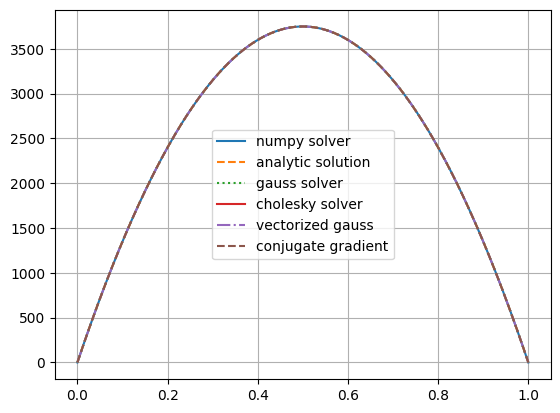

In [ ]:

plt.plot(x,T_numpy, label="numpy solver")
plt.plot(x,T_analytic, label="analytic solution", linestyle="--")
plt.plot(x,T_gauss, label="gauss solver", linestyle=":")
plt.plot(x,T_cholesky, label="cholesky solver", linestyle="-")
plt.plot(x,T_vec_gauss, label="vectorized gauss", linestyle="-.")
plt.plot(x,T_conj_grad, label="conjugate gradient", linestyle="--")
plt.legend()
plt.grid()